Если мы работаем в каггле, склонируем репозиторий и переместимся в него

На 09.06.23 Это аналогично работе в Playground.ipynb

In [19]:
import os

In [20]:
def check_in_kaggle():
    return 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost')

In [21]:

if check_in_kaggle():
    if not os.path.exists("/kaggle/working/image-compression-neural-autoencoder"):
        !git clone https://github.com/proshian/image-compression-neural-autoencoder.git
        %cd image-compression-neural-autoencoder
        !git checkout development
    else:
        %cd /kaggle/working/image-compression-neural-autoencoder
        !git checkout development
        !git pull

In [22]:
from typing import Tuple, List, Dict
import os
import datetime


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import (resnet18,
                                ResNet18_Weights,
                                ResNet,
                                resnet101)
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import skimage.io
from PIL import Image 
import matplotlib.pyplot as plt


from models import (DoubleConv,
                   SimpleResidualUpsampleDoubleConv,
                   SequentialDecoder32x,
                   SimpleResidualDecoder32x,
                   create_resnet_encoder_backbone,
                   Encoder,
                   create_resnet_encoder,
                   NeuralImageCompressor,
                   create_resnet_autoencoder,
                   create_resnet_autoencoder_abs,)

In [23]:
resnet_autoencoder = create_resnet_autoencoder_abs(resnet18(weights=ResNet18_Weights.DEFAULT),
                                              up_func_name = "upsample")

test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [24]:
resnet_autoencoder = create_resnet_autoencoder_abs(resnet18(weights=ResNet18_Weights.DEFAULT))

test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [25]:
resnet_autoencoder

NeuralImageCompressor(
  (encoder): Encoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

In [26]:
# def get_output_channels_of_resnet_encoder(resnet_encoder):
#     num_out_channels = None
#     for module in reversed(resnet_encoder[-1][-1]):
#         if isinstance(module, nn.Conv2d):
#             last_conv = module
#             num_out_channels = module.out_channels
#     return num_out_channels

In [27]:
class ImageFolderSelectedDirs(Dataset):
    def __init__(self, root, dirs=None, transform=None):
        self.root = root
        self.dirs = dirs
        self.transform = transform
        self.images = []
        self._set_images()
    
    def _set_images(self):
        for dir_name in self.dirs:
            dir_path = os.path.join(self.root, dir_name)
            for filename in os.listdir(dir_path):
                self.images.append(
                    os.path.join(
                        dir_path,
                        filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.get_image(idx)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_image(self, idx):
        image_path = self.images[idx]
        image = skimage.io.imread(image_path)
        
        # There are grayscale images in ImageNet
        if len(image.shape) == 2 or image.shape[2] ==1:
            image = self.convert_1ch_to_3ch(image)
        image = Image.fromarray(image)
        return image
    
    @staticmethod
    def convert_1ch_to_3ch(image):
        return np.dstack([image, image, image])

In [28]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_normalize = transforms.Normalize(imagenet_mean, imagenet_std)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.5, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.08, 1.0), ratio=(1., 1.)),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    
}

In [29]:
# datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
# dirs = dirname_to_classname.keys() 
# phases = ["train", "val"]

# dataset_paths = {phase: os.path.join(datasets_path, phase) for phase in phases}
# datasets = {phase: ImageFolderSelectedDirs(root = dataset_paths[phase], dirs = dirs, transform = data_transforms[phase]) for phase in phases}

In [30]:
# source: https://image-net.org/challenges/LSVRC/2011/browse-synsets.php
dirname_to_classname = {
    "n02486410": "baboon",
    "n07720875": "bell pepper",
    "n03124170": "cowboy hat, ten-gallon hat",
    
    "n02493509": "titi, titi monkey",
    "n02110627": "affenpinscher, monkey pinscher, monkey dog",
    "n02493793": "spider monkey, Ateles geoffroyi",
    "n02480855": "gorilla, Gorilla gorilla",
    
    "n07742313": "Granny Smith",
    "n03724870": "mask",
    "n03379051": "football helmet",
    "n04356056": "sunglasses, dark glasses, shades",
    "n04591157": "Windsor tie",
    "n02906734": "broom"
}

In [31]:
# for k in dirname_to_classname.keys():
#     print(f"{k} in class_indx = {k in class_idxs}")

class_idxs = os.listdir("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train")
all(k in class_idxs for k in dirname_to_classname.keys())

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'

In [32]:
datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
dirs = dirname_to_classname.keys() 
phases = ["train", "val"]

train_data_transform = data_transforms["train"]
train_dataset_path  = os.path.join(datasets_root, "train")
train_dataset = ImageFolderSelectedDirs(
    root = train_dataset_path,
    dirs = dirs,
    transform = train_data_transform)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC\\train\\n02486410'

In [75]:
len(train_dataset)

16467

In [76]:
train_dataset[3150].shape

torch.Size([3, 256, 256])

In [77]:
type(train_dataset.get_image(3150))

PIL.Image.Image

In [78]:
type(train_dataset[3150])

torch.Tensor

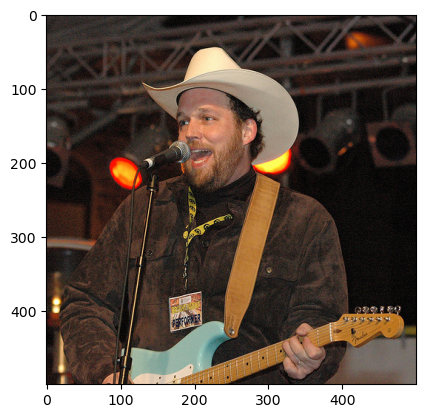

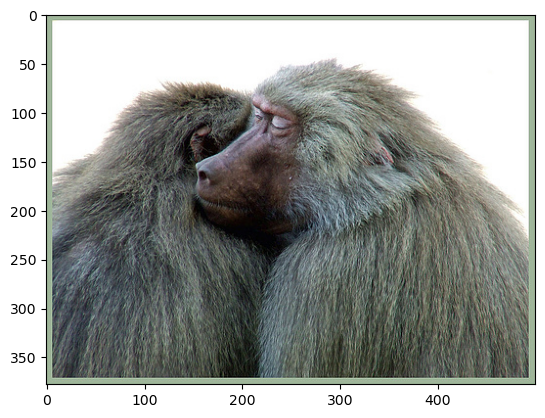

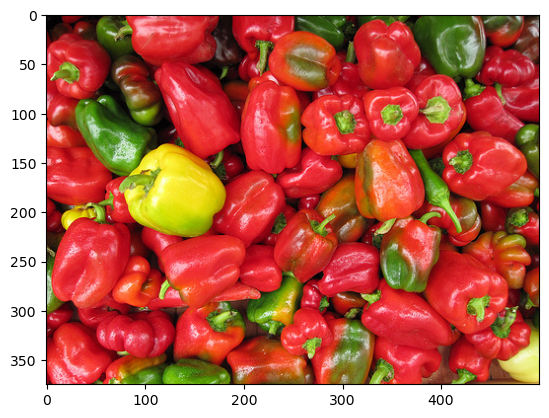

In [79]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.get_image(3150))
plt.show()
plt.imshow(train_dataset.get_image(120))
plt.show()
plt.imshow(train_dataset.get_image(1390))
plt.show()

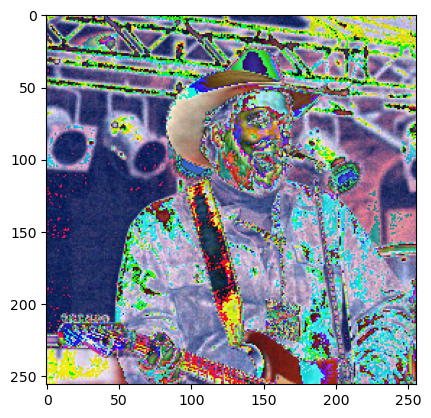

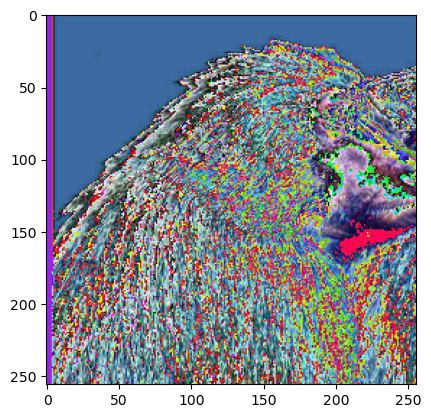

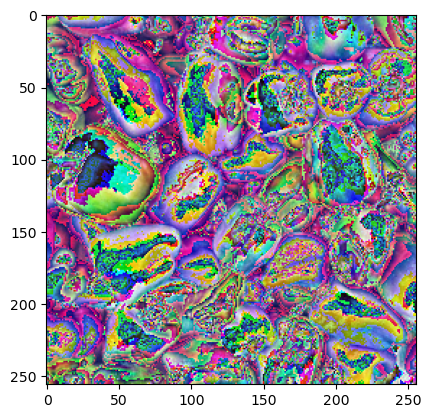

In [80]:
to_pil = transforms.functional.to_pil_image
    
import matplotlib.pyplot as plt
plt.imshow(to_pil(train_dataset[3150]))
plt.show()
plt.imshow(to_pil(train_dataset[120]))
plt.show()
plt.imshow(to_pil(train_dataset[1390]))
plt.show()

In [14]:
def visualize(model, dataset, idxs):
    with torch.no_grad():
        for i in idxs:
            plt.imshow(dataset[i].numpy().transpose(1,2,0))
            plt.show()
            orig_img_on_device = dataset[i].unsqueeze(0).to(device)
            print(orig_img_on_device.count_nonzero())
            decoded_img = model(orig_img_on_device).cpu().detach().squeeze(0)
            plt.imshow(decoded_img.permute(1, 2, 0))
            plt.show()


def train(model, optimizer, criterion,
          dataloaders: Dict[str, DataLoader], epochs,
          phases: List[str] = ["train", "val"], device = None,
          imshow_period: int = 10, save_model_period: int = 10):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()
            else:
                phase_err_msg = 'Phases cannot contain a phase ' \
                                'other than "train" or "val".'
                raise ValueError(phase_err_msg)
            
            epoch_loss = 0

            batch_pbar = tqdm(
                dataloaders[phase],
                total=len(dataloaders[phase]))
                        
            with torch.set_grad_enabled(model.training):
                for img in batch_pbar:
                    img = img.to(device)
                    img_decoded = model(img)

                    loss = criterion(img_decoded, img)
                    epoch_loss += loss
                    
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    progress_string = f"batch mse loss: {loss:.3f}"
                    batch_pbar.set_description(progress_string)
                    # maybe batch_pbar.set_postfix
            
            model.eval()
            if epoch % imshow_period == 0:
                visualize(model, train_dataset, idxs = [0])
            if epoch % save_model_period == 0:
                date_str = datetime.datetime.now().isoformat(timespec='minutes') 
                PATH = f"WIP__residual_decoder__{up_func_name}" \
                       f"__B_{B}__{epoch}_epoch__{date_str}.pt"
                torch.save(model.state_dict(), PATH)
                
    model.eval()

In [15]:
dummy_datasets = {"train": train_dataset, "val": train_dataset}
dummy_dataloaders = {
    "train": DataLoader(train_dataset, batch_size = 64, shuffle = True),
    "val": DataLoader(train_dataset, batch_size = 128, shuffle = False)}

NameError: name 'train_dataset' is not defined

In [33]:
def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result


def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)

In [34]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# B = 6

# up_func_name = "upsample"
# resnet_autoencoder = create_resnet_autoencoder(
#     resnet18(weights=ResNet18_Weights.DEFAULT),
#     up_func_name = up_func_name,
#     B=B,
# ).to(device)
# # resnet_autoencoder.freeze_encoder()
# optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
# criterion = torch.nn.MSELoss() 

# epochs = 100


In [36]:
if check_in_kaggle():
    LOAD_PATH = "/kaggle/input/converted-weights/full__resnet_autoencoder__512x16x16__upsample__B_6__63_epochs_2023-06-08T05_56.pt"
else:
    LOAD_PATH = "weights\\resnet_autoencoder_abs\\full__resnet_autoencoder__512x16x16__upsample__B_6__63_epochs__last_relu__2023-06-08T05_56.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
B = 6

up_func_name = "upsample"
resnet_autoencoder = create_resnet_autoencoder_abs(
    resnet18(weights=ResNet18_Weights.DEFAULT),
    up_func_name = up_func_name,
    B=B,
    last_decoder_activation = nn.ReLU()
).to(device)

resnet_autoencoder.load_state_dict(torch.load(LOAD_PATH, map_location=torch.device(device)))
optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

epochs = 6

In [ ]:
train(resnet_autoencoder, optimizer, criterion,
      dummy_dataloaders, epochs, phases = ["train"],
      save_model_period  = 3, imshow_period = 3)

In [17]:
resnet_autoencoder.eval()
visualize(resnet_autoencoder, train_dataset, [0, 5, 10])

NameError: name 'train_dataset' is not defined

In [37]:
def img_path_to_model_input(img_path: str, inference_data_transform = data_transforms['test']):
    image = Image.fromarray(skimage.io.imread(img_path))
    image = (image)
    image = inference_data_transform(image)
    return image



def show_dir_imgs(dir_name: str, model, data_transform = data_transforms['test'],
                  scale_factor: int = 3, device = None) -> None:
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    fig, axs = plt.subplots(2, 3, dpi=80)
    plt.axis('off')


    for i, img_name in enumerate(os.listdir(dir_name)):
        image = img_path_to_model_input(os.path.join(dir_name, img_name))

        orig_img_on_device = image.unsqueeze(0).to(device)
        decoded_img = model(
            orig_img_on_device).cpu().detach().squeeze(0)
        
        axs[0, i].imshow(denormalize_imagenet(image).numpy().transpose(1,2,0))
        axs[1, i].imshow(denormalize_imagenet(decoded_img).permute(1, 2, 0))

    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_size_inches(fig.get_size_inches()*scale_factor)  # double the default size

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


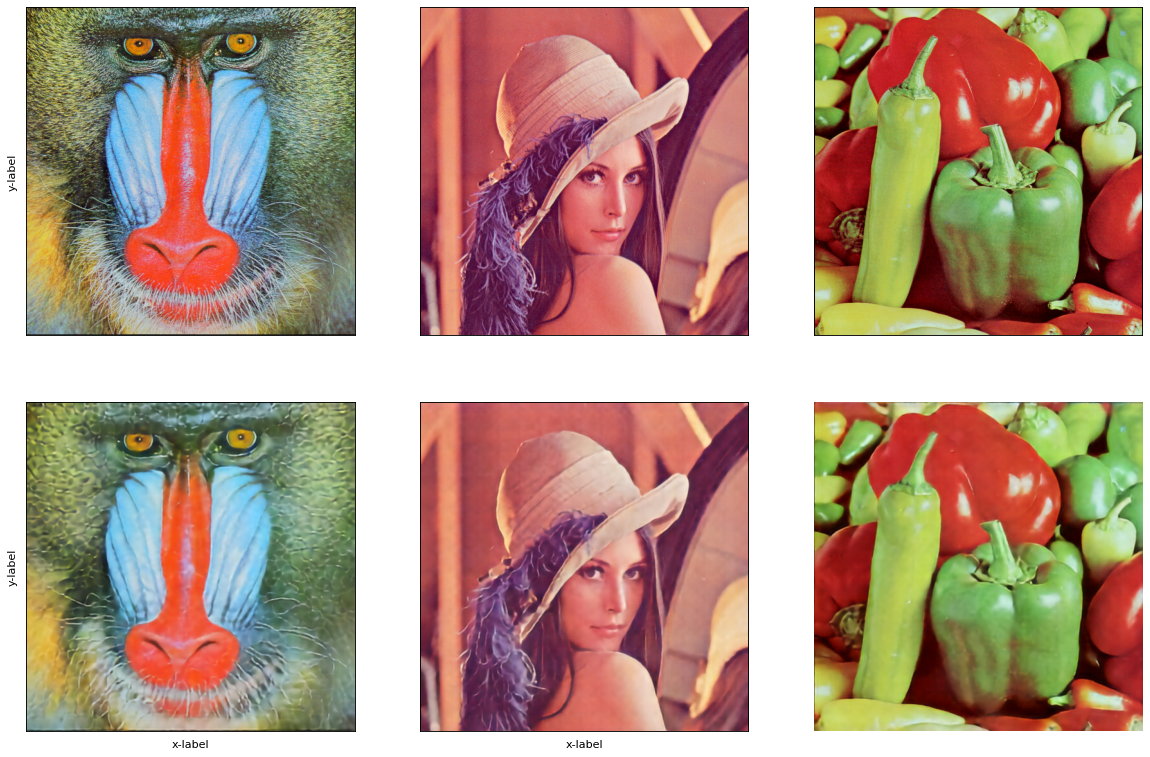

In [39]:
resnet_autoencoder.eval()
if check_in_kaggle():
    lab_imgs_path = "/kaggle/input/compression-lab-imgs"
else:
    lab_imgs_path = "compression-lab-imgs"

show_dir_imgs(lab_imgs_path, resnet_autoencoder)

```
path_example = f"residual_decoder__{up_func_name}__B_{B}__{epochs}_epochs_{date_str}.pt"
```

In [ ]:
epoch_bias = 0
date_str = datetime.datetime.now().isoformat(timespec='minutes') 

PATH = f"residual_decoder__{up_func_name}__B_{B}__{epochs + epoch_bias}_epochs_{date_str}.pt"

torch.save(resnet_autoencoder.state_dict(), PATH)

In [ ]:
resnet_autoencoder = create_resnet_autoencoder(
    resnet18(weights=ResNet18_Weights.DEFAULT),
    up_func_name =up_func_name,
    B = B)

resnet_autoencoder.load_state_dict(torch.load(PATH))